In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import cv2 
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from Trainer import train_model
from Dataloader import JetcarDataset, SimulatorDataset 
# from Models import NetworkNvidia

In [4]:
transforms = torch.nn.Sequential(
    T.RandomResizedCrop(size=(224, 224),scale=(0.5,1)),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4)),
    T.ColorJitter(brightness=.3, hue=.3, saturation=.3),
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
) 

In [5]:
realData = JetcarDataset("data/data.csv", "data/img/", transform=transforms)
x,y = realData[1]
print(x,y)

[[[0.6044329  0.60665095 0.6108891  ... 0.77924514 0.7730067  0.7700228 ]
  [0.6046599  0.6068139  0.61119103 ... 0.77979624 0.77375585 0.7708843 ]
  [0.60471314 0.6065993  0.6114316  ... 0.78136814 0.7755076  0.7726657 ]
  ...
  [0.8321145  0.832547   0.8326599  ... 0.84576523 0.8483002  0.84969413]
  [0.8322953  0.83278835 0.83285034 ... 0.8462057  0.8488064  0.85018194]
  [0.8322286  0.83275616 0.8328601  ... 0.8463661  0.84902453 0.85042   ]]

 [[0.3813573  0.38294518 0.38674343 ... 0.58483374 0.5674261  0.5590782 ]
  [0.38152874 0.3830793  0.38706034 ... 0.58664334 0.5698167  0.56180507]
  [0.3819601  0.38336074 0.38765478 ... 0.5901308  0.57431793 0.5668409 ]
  ...
  [0.5587517  0.55853236 0.55742264 ... 0.5358512  0.5358256  0.5355879 ]
  [0.55824465 0.55798817 0.5569867  ... 0.53589606 0.5359787  0.5357469 ]
  [0.5581632  0.55789196 0.55691046 ... 0.5360726  0.5362485  0.53600323]]

 [[0.70432127 0.70562804 0.70798266 ... 0.74319017 0.75115526 0.7550933 ]
  [0.70436525 0.705639

In [6]:
realData = JetcarDataset("data/data.csv", "data/img/", transform=transforms)
x,y = realData[0]
x.shape

(3, 224, 224)

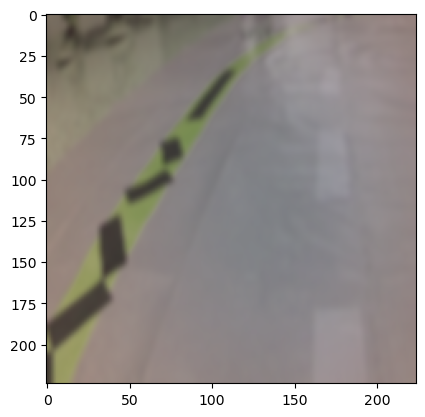

In [7]:
img, label = realData.get_rgb(100)
plt.imshow(img)

In [8]:
label

array([ 0., -0.], dtype=float32)

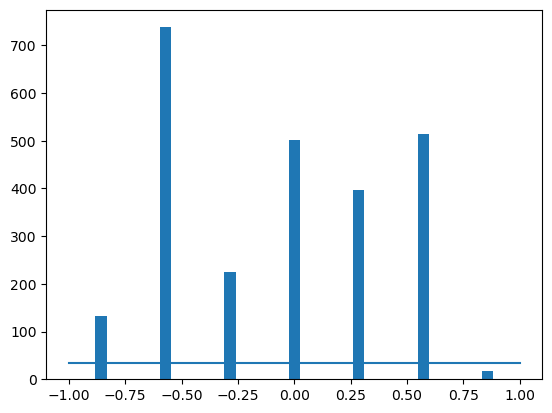

In [9]:
realData.plot_hist()

In [10]:
realData.__len__()

2526

In [11]:
train_generator = DataLoader(realData, batch_size=8, shuffle=True)

In [12]:
x,y = next(iter(train_generator))

In [13]:
x.shape

torch.Size([8, 3, 224, 224])

In [14]:
class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.
        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 (output)
        the convolution layers are meant to handle feature engineering.
        the fully connected layer for predicting the steering angle.
        the elu activation function is for taking care of vanishing gradient problem.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48576, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=2) 
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 224, 244)
        output = self.conv_layers(input)
        print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


class LeNet(nn.Module):
    """LeNet architecture."""

    def __init__(self):
        """Initialization."""
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1   = nn.Linear(70224, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 2)

    def forward(self, x):
        """Forward pass."""
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [15]:
model = NetworkNvidia()

In [16]:
print(model)

NetworkNvidia(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=48576, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [17]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)

/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9) 
# optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [20]:
device = torch.device("mps")

In [21]:
net, train_loss, test_loss = train_model(30,model,train_generator,None,criterion,optimizer, device=device)

Epoch: 1/30 	Train Loss: 0.033784
Test loss decreased (inf --> 0.033784. Saving model...
Epoch: 2/30 	Train Loss: 0.010776
Test loss decreased (0.033784 --> 0.010776. Saving model...
Epoch: 3/30 	Train Loss: 0.009503
Test loss decreased (0.010776 --> 0.009503. Saving model...
Epoch: 4/30 	Train Loss: 0.007651
Test loss decreased (0.009503 --> 0.007651. Saving model...
Epoch: 5/30 	Train Loss: 0.008694
Epoch: 6/30 	Train Loss: 0.007236
Test loss decreased (0.007651 --> 0.007236. Saving model...
Epoch: 7/30 	Train Loss: 0.005235
Test loss decreased (0.007236 --> 0.005235. Saving model...
Epoch: 8/30 	Train Loss: 0.004334
Test loss decreased (0.005235 --> 0.004334. Saving model...


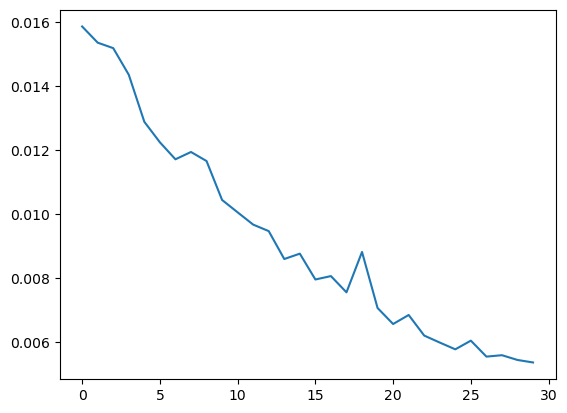

In [ ]:
plt.plot(train_loss)

In [17]:
x,y = next(iter(train_generator))
out = model(x.to(device))
print(out)

/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[ 0.3963,  0.6038],
        [-0.3820,  0.5753],
        [-0.1717,  0.3188],
        [ 0.1367,  0.6002],
        [ 0.0879,  0.5005],
        [-0.5098,  0.6256],
        [ 0.3793,  0.6296],
        [-0.1457,  0.5462]], device='mps:0', grad_fn=<LinearBackward0>)


In [33]:
out[0]

tensor([0.3963, 0.6038], device='mps:0', grad_fn=<SelectBackward0>)

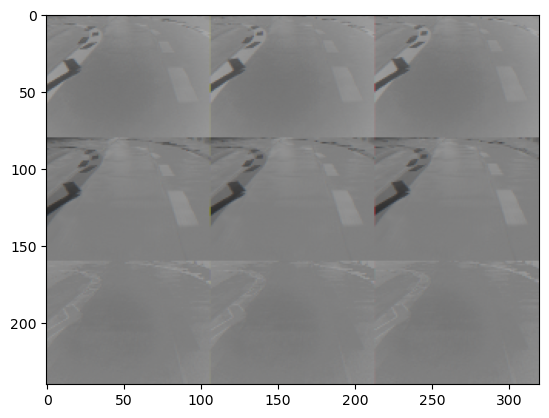

In [30]:
plt.imshow(np.array(x[7].reshape(240,320,3)))

In [85]:
x,y = next(iter(train_generator))
out = model(x.to(device))
print(out)

tensor([[-0.1045,  0.2120],
        [-0.1014,  0.2239],
        [-0.5670,  0.2515],
        [-0.2095,  0.2164]], device='mps:0', grad_fn=<LinearBackward0>)


In [86]:
y

tensor([[ 0.4330,  0.2165],
        [ 0.0618,  0.2165],
        [-1.0000,  0.2371],
        [-0.8660,  0.1753]])

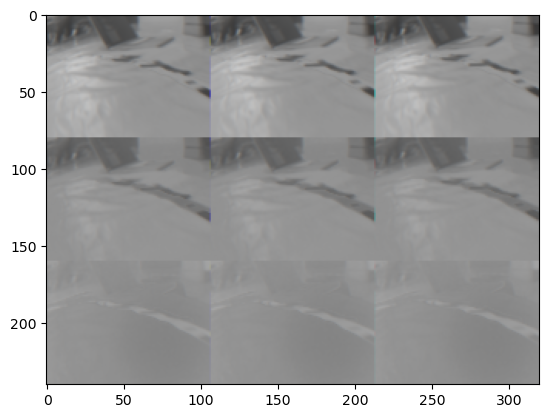

In [91]:
plt.imshow(np.array(x[2].reshape(240,320,3)))

In [99]:
x.max()

tensor(1.)